In [1]:
import ee
import geemap
import pandas as pd
from matplotlib import pyplot


#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [2]:
lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
    .filter(ee.Filter.eq('GNIS_Name', 'Big Moose Lake'))



In [3]:
data = pd.read_csv("C:\\Users\\Touhe\\TimeSeriesGenerationData_excel.csv", index_col=0,parse_dates=True)

# Drop rows with null values
data = data.dropna()
# Sort the DataFrame by date in ascending order
data = data.sort_index()

# Set the display options to expand all rows
# Use the pd.options.display context manager to show all rows
with pd.option_context('display.max_rows', None):
    print(data)
    




                 DOC
date                
1982-07-29  5.200000
1982-08-31  2.900000
1982-09-24  3.600000
1982-10-22  4.300000
1983-07-25  2.900000
1983-09-02  2.700000
1983-10-04  2.800000
1984-07-25  2.700000
1984-08-23  2.900000
1984-09-21  3.000000
1984-10-21  2.800000
1985-07-23  3.000000
1985-08-20  2.200000
1985-09-23  2.100000
1985-10-27  3.300000
1986-07-16  3.300000
1986-08-12  4.400000
1986-09-11  4.100000
1986-10-23  5.200000
1987-07-31  3.700000
1987-08-30  3.400000
1987-09-29  3.600000
1987-10-29  3.500000
1988-08-07  2.200000
1988-09-04  2.200000
1988-10-01  2.100000
1989-07-11  2.900000
1989-08-06  2.700000
1989-09-30  3.500000
1990-07-01  3.400000
1990-08-04  2.900000
1990-09-02  3.500000
1990-10-05  3.300000
1991-07-09  3.500000
1991-08-10  6.100000
1991-09-09  2.700000
1991-10-07  3.100000
1992-07-07  5.484000
1992-08-04  5.171000
1992-09-02  3.522000
1992-10-06  3.947000
1993-07-13  2.965000
1993-08-10  2.539000
1993-09-01  2.653000
1993-10-04  2.912000
1994-07-07  2

In [4]:
station = ee.Geometry.Point(-74.85423940003443,43.81880036802749)
Map.addLayer(station)
Map.centerObject(station, 16)
Map

Map(center=[43.81880036802749, -74.85423940003443], controls=(WidgetControl(options=['position', 'transparent_…

In [5]:
LC5_BANDS = ['SR_B1',   'SR_B2',    'SR_B3',  'SR_B4',  'SR_B5',    'SR_B7',    'ST_B6','QA_PIXEL']; #Llandsat 5
LC8_BANDS = ['SR_B2','SR_B3','SR_B4',  'SR_B5','SR_B6','SR_B7','ST_B10','QA_PIXEL']; #Landsat 8
STD_NAMES = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'temp','QA'];


In [6]:
def cdom(img):
    co = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b1' : img.select('blue'),
        'b2' : img.select('green'),
        'b3' : img.select('red'),
        'b4' : img.select('nir')
    }).rename("CO")
    return img.addBands([co])


In [7]:
def maskL457sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    qa = image.select('QA_PIXEL')
    cloud = qa.bitwiseAnd(1 << 5).Or(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
    masked = image.updateMask(cloud.Not())
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(-124.15)
    return image.addBands(opticalBands, None, True).addBands(thermalBand, None, True).updateMask(masked).updateMask(qaMask).updateMask(saturationMask)


l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
   .filter(ee.Filter.calendarRange(5, 11, 'month')) \
   .filterBounds(station) \
   .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
   .map(maskL457sr)\
   .select(LC5_BANDS, STD_NAMES)\
   .map(cdom)\
   

#l5 = l5


In [8]:
def maskL8sr(image):
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(-124.15)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
        .addBands(thermalBands, None, True) \
        .updateMask(qaMask) \
        .updateMask(saturationMask)

l8 =ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(5, 11, 'month')) \
    .filterBounds(station) \
    .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
    .map(maskL8sr) \
    .select(LC8_BANDS, STD_NAMES)\
    .map(cdom) \

#l8 = l8


#merge landsat 5 and landsat 8
lall = ee.ImageCollection(l5.merge(l8));




In [9]:
def station_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=station, scale=30).get('CO')
    return img.set('date', img.date().format()).set('CDOM',mean)

In [10]:
station_reduced_imgs = lall.map(station_mean)


In [11]:
nested_list = station_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','CDOM']).values().get(0)

In [12]:
df = pd.DataFrame(nested_list.getInfo(), columns=['date','CDOM'])

df

,date,CDOM
0,1984-07-03T15:07:36,7.134586
1,1988-06-12T15:09:37,2.375961
2,1988-07-30T15:09:49,-3.724421
3,1989-08-18T15:05:40,8.205134
4,1992-05-22T15:02:40,6.750698
...,...,...
183,2022-08-20T15:45:47,5.682620
184,2022-09-21T15:45:54,5.666510
185,2022-11-08T15:45:52,8.686536
186,2022-11-24T15:45:48,13.602664


In [13]:
# dont forget we need to call the callback method "getInfo" to retrieve the data
df = pd.DataFrame(nested_list.getInfo(), columns=['date','CDOM'])
pd.set_option('display.max_rows', None)

df

,date,CDOM
0,1984-07-03T15:07:36,7.134586
1,1988-06-12T15:09:37,2.375961
2,1988-07-30T15:09:49,-3.724421
3,1989-08-18T15:05:40,8.205134
4,1992-05-22T15:02:40,6.750698
5,1992-07-25T15:01:56,6.618089
6,1994-06-13T14:58:02,6.527399
7,1995-05-31T14:45:55,4.461171
8,1995-06-16T14:45:12,4.714479
9,1999-06-11T15:17:03,-1.430143


In [14]:
df['date'] = pd.to_datetime(df['date'])

# Format 'date' column to exclude the time
df['date'] = df['date'].dt.date
df

,date,CDOM
0,1984-07-03,7.134586
1,1988-06-12,2.375961
2,1988-07-30,-3.724421
3,1989-08-18,8.205134
4,1992-05-22,6.750698
5,1992-07-25,6.618089
6,1994-06-13,6.527399
7,1995-05-31,4.461171
8,1995-06-16,4.714479
9,1999-06-11,-1.430143


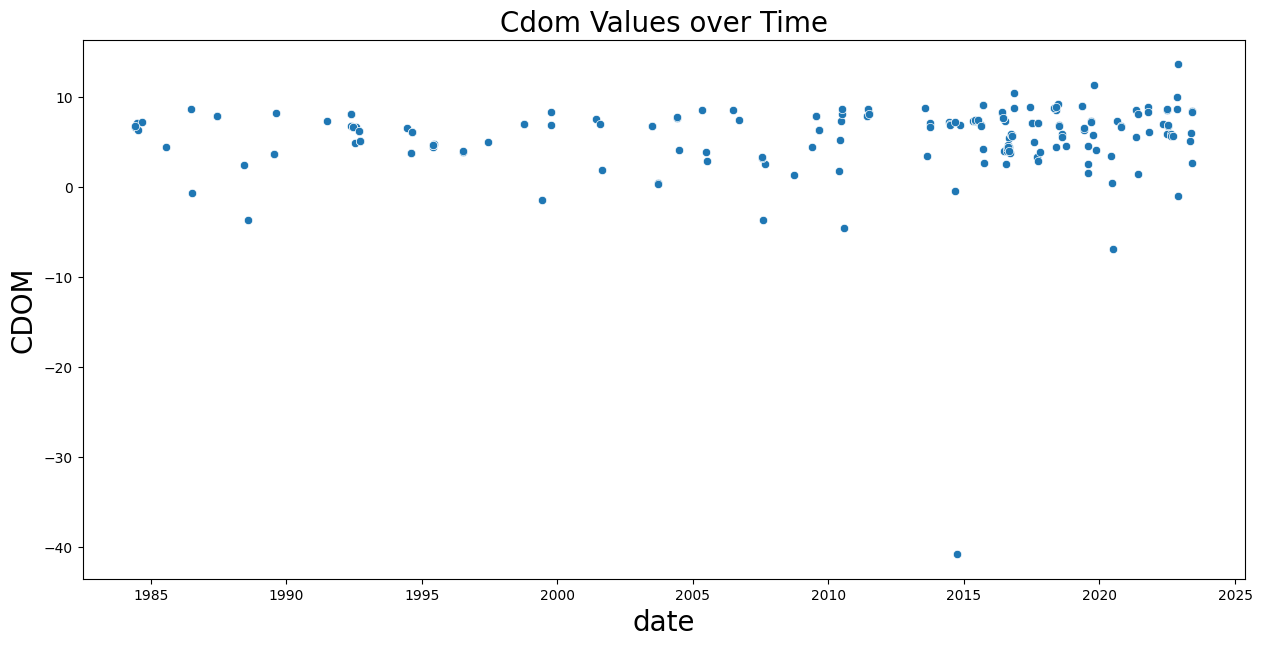

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax)

# Set the labels and title
ax.set_ylabel('CDOM', fontsize=20)
ax.set_xlabel('date', fontsize=20)
ax.set_title('Cdom Values over Time', fontsize=20)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# Display the plot
plt.show()


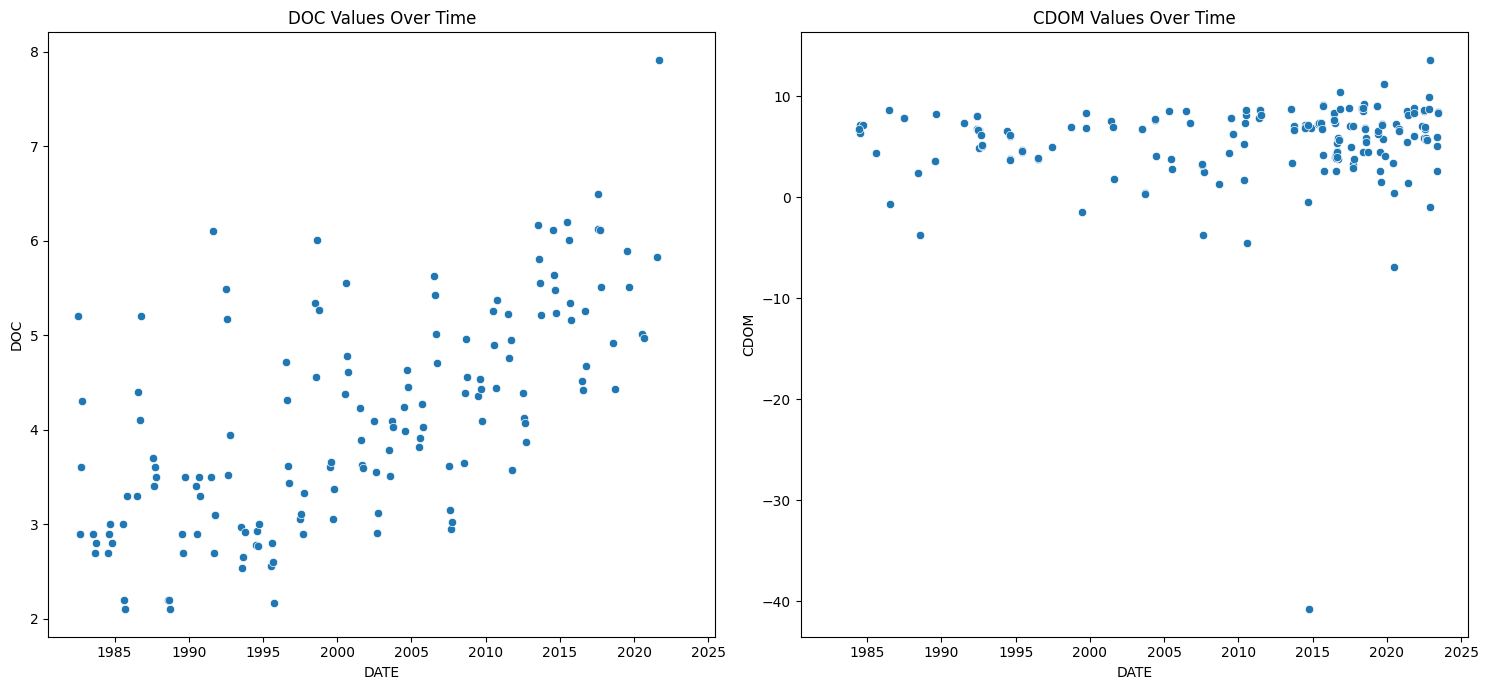

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharex=True)

# Seaborn scatter plot
sns.scatterplot(data=data, x=data.index, y='DOC', ax=ax1)
ax1.set_xlabel('DATE')
ax1.set_ylabel('DOC')
ax1.set_title('DOC Values Over Time')

# Seaborn scatter plot
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax2)
ax2.set_xlabel('DATE')
ax2.set_ylabel('CDOM')
ax2.set_title('CDOM Values Over Time')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


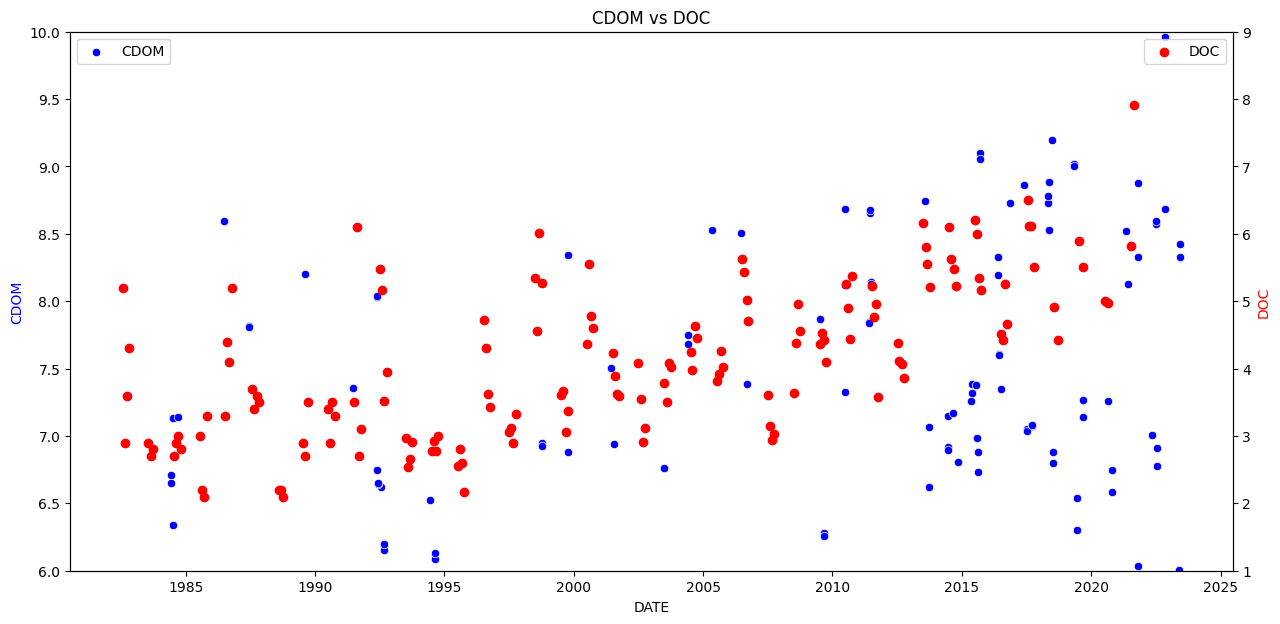

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Seaborn scatter plot for CDOM
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax, label='CDOM', color='blue')

# Create a twin Axes object for DOC
ax2 = ax.twinx()

# Matplotlib scatter plot for DOC
ax2.scatter(data.index, data['DOC'], label='DOC', color='red')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('CDOM vs DOC')

# Set different ranges for the y-axes
ax.set_ylim(6, 10)  # Adjust the range for CDOM
ax2.set_ylim(1, 9)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()


In [18]:
# Sort the doc DataFrame by date in ascending order
data = data.sort_index()

# Sort the keys in the 'date' column of df(CDOM) in ascending order
df.sort_values('date', inplace=True)

# Convert 'date' column in df(CDOM) to datetime dtype
df['date'] = pd.to_datetime(df['date'])



# Perform inner merge with three-day window
merged_inner = pd.merge_asof(df, data, left_on='date', right_on='date', tolerance=pd.Timedelta(days=3))

#Get rid of the null values from doc
merged_inner = merged_inner.dropna()

print(merged_inner)


          date      CDOM     DOC
7   1986-07-16 -0.679741  3.3000
23  1992-09-02  6.151697  3.5220
24  1992-09-02  6.199192  3.5220
36  1996-07-11  3.820823  4.7160
37  1996-07-11  3.931802  4.7160
39  1998-10-05  6.949976  5.2650
40  1998-10-05  6.923416  5.2650
42  1999-10-08  6.881710  3.3690
43  1999-10-08  8.339657  3.3690
111 2016-08-03  4.298291  4.4201
112 2016-08-03  3.928245  4.4201
121 2016-10-06  5.637163  4.6685
122 2016-10-06  5.744368  4.6685


In [19]:
# Drop duplicate rows based on DOC column, keeping the first occurrence
merged_inner = merged_inner.drop_duplicates(subset=['DOC'])

# Print the updated DataFrame
print(merged_inner)


          date      CDOM     DOC
7   1986-07-16 -0.679741  3.3000
23  1992-09-02  6.151697  3.5220
36  1996-07-11  3.820823  4.7160
39  1998-10-05  6.949976  5.2650
42  1999-10-08  6.881710  3.3690
111 2016-08-03  4.298291  4.4201
121 2016-10-06  5.637163  4.6685


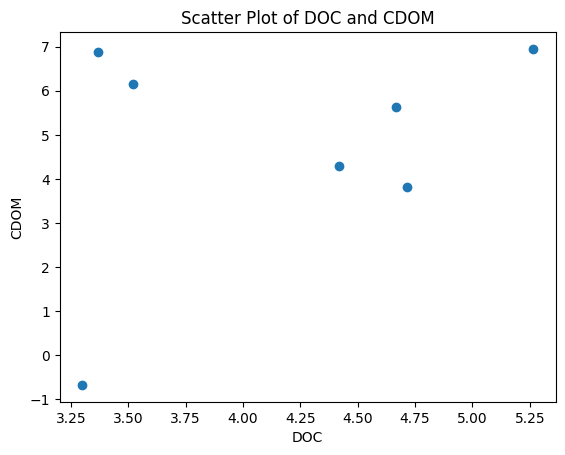

In [20]:
import matplotlib.pyplot as plt

# Plotting the scatter plot
plt.scatter(merged_inner['DOC'], merged_inner['CDOM'])

# Setting labels and title
plt.xlabel('DOC')
plt.ylabel('CDOM')
plt.title('Scatter Plot of DOC and CDOM')

# Displaying the plot
plt.show()
